In [42]:
# https://github.com/mateuszjanczak/koronawirus-api

import http.client
import datetime as dt
import numpy as np
import collections
import pandas
import re
from time import sleep
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
%matplotlib inline

In [43]:
start_date = dt.date(2021, 8, 1)
end_date = dt.date(2021, 12, 5)
case="Active"   # Confirmed_Total Recovered Deaths New_Infections New_Deaths Active

In [44]:
conn = http.client.HTTPSConnection("koronawirus-api.herokuapp.com")

def live_plot(data_dict, date, figsize=(7,5), title=''):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    now = date
    then = now + dt.timedelta(days=len(data_dict))
    days = mdates.drange(now,then,dt.timedelta(days=1))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=int(np.sqrt(len(data_dict)))))
    for label,data in data_dict.items():
        plt.plot(days,data,label=label)
    plt.title(title)
    plt.grid(False)
    plt.xlabel('Time')
    plt.legend(loc='upper left') 
    plt.gcf().autofmt_xdate()
    plt.show();

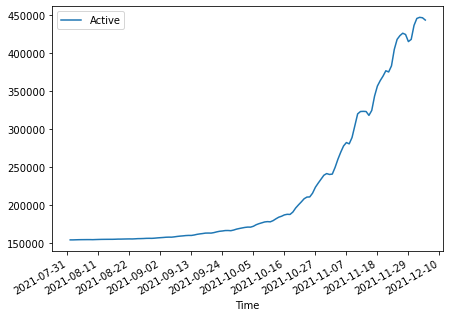

In [45]:
df = pandas.DataFrame(columns=['Date','Confirmed_Total','Recovered','Deaths','New_Infections','New_Deaths','Active'])
df_plot = pandas.DataFrame(columns=[])
print_status=0
first_date=start_date

while start_date <= end_date:
    date=start_date.strftime("%Y-%m-%d")
    start_date += dt.timedelta(days=1) 
    conn.request("GET", f"/api/covid19/from/{date}/to/{start_date}/")
    res = conn.getresponse()
    data = res.read()
    data_string = data.decode("utf-8")
    terminator = data_string.index('AgeRanges')
    data_string=data_string[:terminator]
    m = re.search('"infections":(.*),"deaths":(.*),"recovered":(.*)},"today":{"newInfections":(.*),"newDeaths":(.*),"death', data_string)
    df = df.append({'Date':date, 'Confirmed_Total':int(m.group(1)), 'Recovered':int(m.group(3)), 'Deaths':int(m.group(2)), 'New_Infections':int(m.group(4)), 'New_Deaths':int(m.group(5)), 'Active':int(m.group(1))- int(m.group(3))-int(m.group(2))}, ignore_index=True)
    if case=="Confirmed_Total":
        df_plot= df_plot.append({'Confirmed_Total':int(m.group(1))}, ignore_index=True)
        live_plot(df_plot,first_date)
    elif case=="Recovered":
        df_plot= df_plot.append({'Recovered':int(m.group(3))}, ignore_index=True)
        live_plot(df_plot,first_date)
    elif case=="Deaths":
        df_plot= df_plot.append({'Deaths':int(m.group(2))}, ignore_index=True)
        live_plot(df_plot,first_date)
    elif case=="New_Infections":
        df_plot= df_plot.append({'New_Infections':int(m.group(4))}, ignore_index=True)
        live_plot(df_plot,first_date)
    elif case=="New_Deaths":
        df_plot= df_plot.append({'New_Deaths':int(m.group(5))}, ignore_index=True)
        live_plot(df_plot,first_date)
    elif case=="Active":
        df_plot= df_plot.append({'Active':int(m.group(1))- int(m.group(3))-int(m.group(2))}, ignore_index=True)
        live_plot(df_plot,first_date)
    else:
        if print_status==0:
            print("Wrong plot case")
            print_status=1
        else:
            pass
        